In [1]:
from backtest.polymarket_fetcher import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
config = {
    "private_key": os.getenv("POLYMARKET_PRIVATE_KEY"),
    "funder": os.getenv("POLYMARKET_FUNDER"),
}

exchange = PolymarketFetcher(config)
print(f"Polymarket time-series ready ({'authenticated' if exchange.private_key else 'public'})")

Polymarket time-series ready (authenticated)


In [3]:
#https://docs.polymarket.com/developers/gamma-markets-api/get-markets

crypto_tag = exchange.get_tag_by_slug('crypto')
crypto_hourly = exchange.get_tag_by_slug('1H')
crypto_15min = exchange.get_tag_by_slug('15M')
crypto_daily = exchange.get_tag_by_slug('today')
crypto_hit = exchange.get_tag_by_slug('hit-price')
election = exchange.get_tag_by_slug('election')

crypto_hourly_markets = exchange.search_markets(
    limit=500,
    tag_id=crypto_daily.id,
    keywords = ['bitcoin', 'up or down'],
    closed=True,
    binary=True,
    min_liquidity=0.0,
)

crypto_hourly_markets[:5]

[Market(id='685758', question='Bitcoin Up or Down on November 18?', outcomes=['Up', 'Down'], close_time=datetime.datetime(2025, 11, 18, 17, 0, tzinfo=datetime.timezone.utc), volume=595421.639932, liquidity=0.0, prices={'Down': 1.0}, metadata={'id': '685758', 'question': 'Bitcoin Up or Down on November 18?', 'conditionId': '0xe60e3435a7268ea01ef8fed2baf3ac8d6cdfa24fe88b318042c0696b7dbc1549', 'slug': 'bitcoin-up-or-down-on-november-18', 'resolutionSource': 'https://www.binance.com/en/trade/BTC_USDT', 'endDate': '2025-11-18T17:00:00Z', 'startDate': '2025-11-16T17:01:03.497401Z', 'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png', 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png', 'description': 'This market will resolve to "Up" if the "Close" price for the Binance 1 minute candle for BTC/USDT Nov 17 \'25 12:00 in the ET timezone (noon) is lower than the final "Close" price for the Nov 18 \'25 12:00 ET candle.\n\nThis market will 

In [4]:
epl_tag = exchange.get_tag_by_slug('EPL')

tottenham_markets = exchange.search_markets(
        limit=500,
        tag_id=epl_tag.id,
        keywords=['will tottenham win on'],
        closed=True,
        binary=True,
    )

tottenham_markets[:5]

[Market(id='650101', question='Will Tottenham win on 2025-11-08?', outcomes=['Yes', 'No'], close_time=datetime.datetime(2025, 11, 8, 12, 30, tzinfo=datetime.timezone.utc), volume=614787.624804, liquidity=0.0, prices={'No': 1.0}, metadata={'id': '650101', 'question': 'Will Tottenham win on 2025-11-08?', 'conditionId': '0x4164cca7c5da1cfc6d9684651f308188ddbbbd8fe1e54402f20c9df732386cd9', 'slug': 'epl-tot-mun-2025-11-08-tot', 'resolutionSource': 'https://www.premierleague.com/', 'endDate': '2025-11-08T12:30:00Z', 'startDate': '2025-10-26T04:14:48.949392Z', 'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/Repetitive-markets/premier+league.jpg', 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/Repetitive-markets/premier+league.jpg', 'description': 'In the upcoming game, scheduled for November 8, 2025\nIf Tottenham wins, this market will resolve to "Yes".\nOtherwise, this market will resolve to "No".\nIf the game is postponed, this market will remain open until the

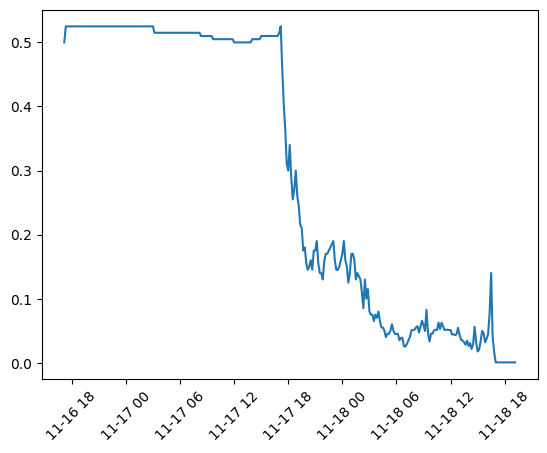

In [7]:
target_market = crypto_hourly_markets[0]

df = exchange.fetch_price_history(target_market, interval="max", fidelity=1, as_dataframe=True)
plt.plot(df['timestamp'], df['price'])
plt.xticks(rotation=45)
plt.show()

In [8]:
tmp_trades = exchange.fetch_public_trades(market=target_market, limit=10000)

In [9]:
trades = pd.DataFrame(tmp_trades)
up_trades = trades[trades['outcome']=='Up'].set_index('timestamp').sort_index()
up_trades[['side', 'price']]

,side,price
timestamp,,
2025-11-18 08:38:39+00:00,BUY,0.060
2025-11-18 08:38:39+00:00,BUY,0.060
2025-11-18 08:38:39+00:00,BUY,0.060
2025-11-18 08:38:39+00:00,BUY,0.060
2025-11-18 08:38:39+00:00,BUY,0.060
...,...,...
2025-11-18 18:02:03+00:00,BUY,0.001
2025-11-18 18:05:13+00:00,BUY,0.001
2025-11-18 18:06:37+00:00,BUY,0.001


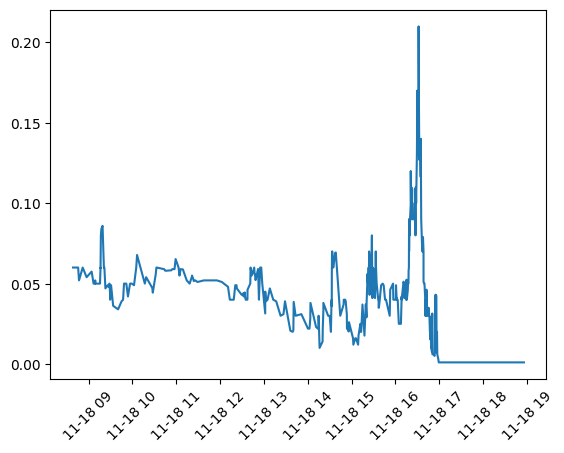

In [11]:
plt.plot(up_trades['price'])
plt.xticks(rotation=45)
plt.show()

In [13]:
aespakarina = '0xca85f4b9e472b542e1df039594eeaebb6d466bf2'
#tmp_market='0xbb877d541d16896757c57107abe0632450ce1bedb4a46d4eae8ba1d1978207a6'
#user_trades = exchange.fetch_public_trades(market=tmp_market, user=aespakarina, limit=1000)
aespakarina_trades = exchange.fetch_public_trades(user=aespakarina, limit=100)
aespakarina_trades[:5]

[PublicTrade(proxy_wallet='0xca85f4b9e472b542e1df039594eeaebb6d466bf2', side='SELL', asset='106651843519470994985930974408601442891724292582511005763049746003139804181872', condition_id='0xbb877d541d16896757c57107abe0632450ce1bedb4a46d4eae8ba1d1978207a6', size=50.0, price=0.97, timestamp=datetime.datetime(2025, 11, 16, 13, 42, 47, tzinfo=datetime.timezone.utc), title='Bitcoin Up or Down - November 16, 8:30AM-8:45AM ET', slug='btc-updown-15m-1763299800', icon='https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png', event_slug='btc-updown-15m-1763299800', outcome='Down', outcome_index=1, name='aespakarina', pseudonym='Idle-Exaggeration', bio='one look give em whiplash', profile_image='https://polymarket-upload.s3.us-east-2.amazonaws.com/profile-image-903202-8b12b8b3-d90d-4357-98bc-2816f761a91e.jpg', profile_image_optimized='', transaction_hash='0x574628efe0285611c5d71703beec3341e8660bdd6be0a23580afd938e8e9dcf0'),
 PublicTrade(proxy_wallet='0xca85f4b9e472b542e1df039594eeae